In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:40:08 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   29C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader
from monai.data.utils import pad_list_data_collate


import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)
df.rename(columns= {'ART': 'IMAGE'}, inplace = True)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

## Setup Input Transformations

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=PATCH_SIZE, mode=('reflect','reflect'), ),
    #DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=8),
    RandFlipd(keys=['IMAGE', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
     LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['IMAGE'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE']),
    Orientationd(keys=['IMAGE'], axcodes='RAS'),
    Spacingd(keys=['IMAGE'], pixdim=SPACING, mode=('bilinear'), padding_mode=('reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=pad_list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=pad_list_data_collate)#list_data_collate)

In [12]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, collate_fn=pad_list_data_collate)

## Check Input Data

torch.Size([96, 1, 64, 64, 32])
image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.4179016649723053


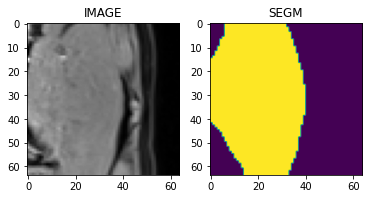

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5959601402282715


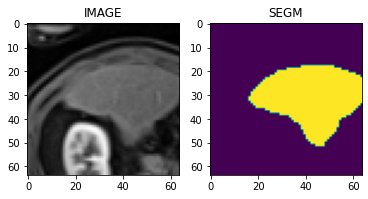

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.23652632534503937


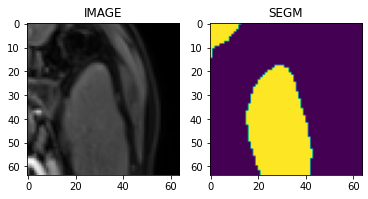

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8010719418525696


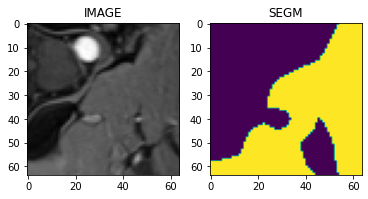

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.3372603952884674


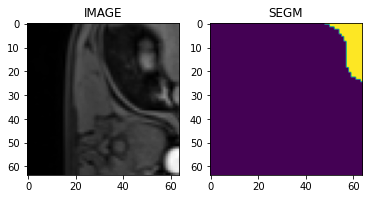

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7503330707550049


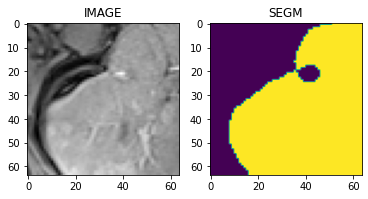

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.2682519853115082


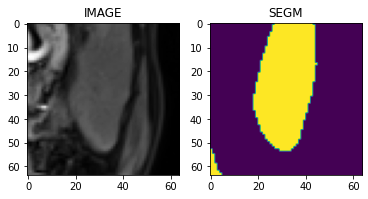

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.43872779607772827


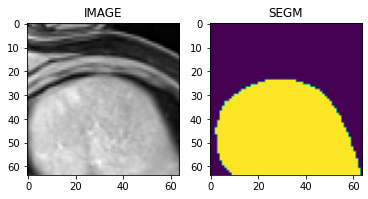

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.760644793510437


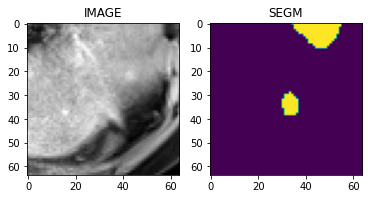

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.14709050953388214


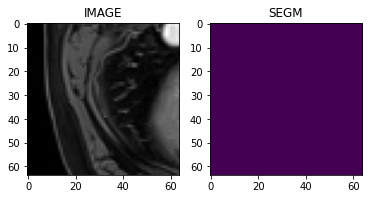

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.24719417095184326


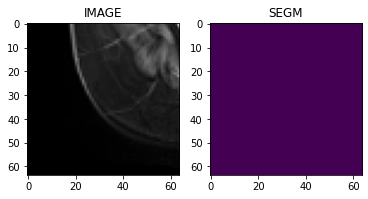

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.1827736645936966


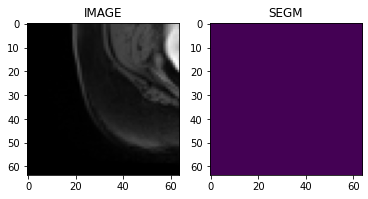

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.9797983765602112


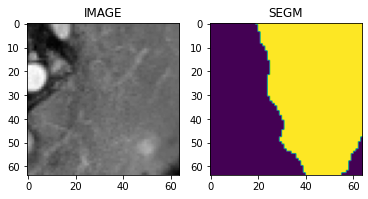

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8056020140647888


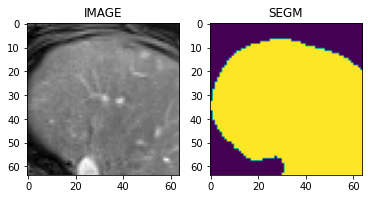

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5561124682426453


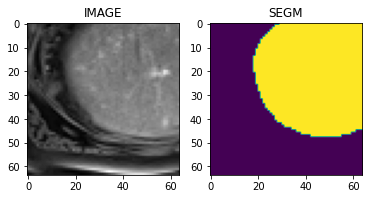

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.2067263126373291


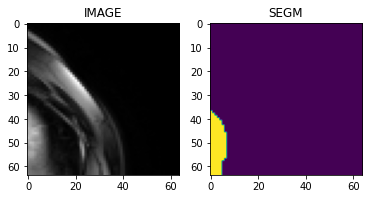

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.139299750328064


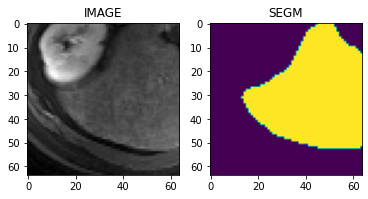

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.28588125109672546


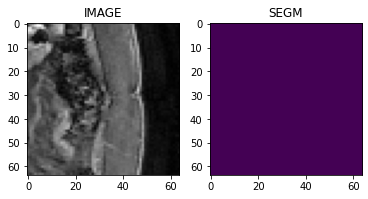

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5707963705062866


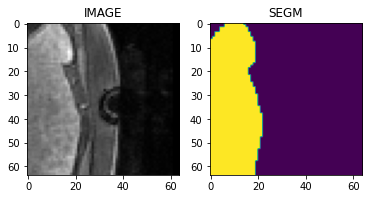

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5513531565666199


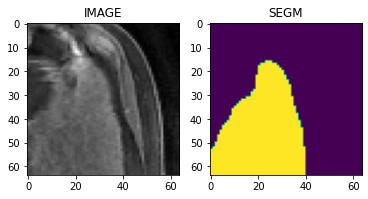

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.342276006937027


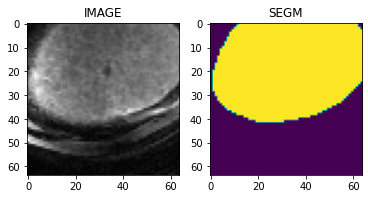

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.9087238311767578


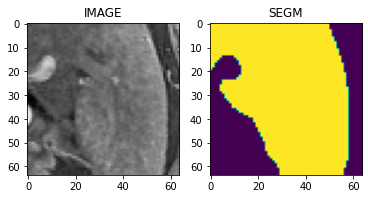

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.1202043294906616


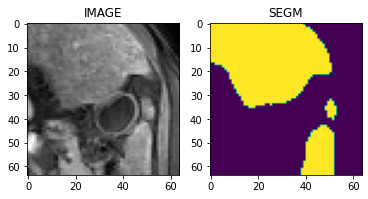

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.15834034979343414


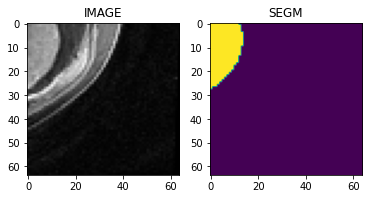

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8077679872512817


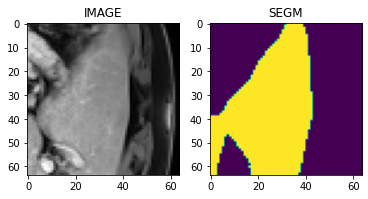

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8962373733520508


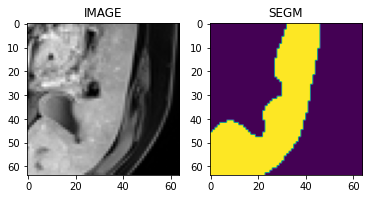

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.9135376811027527


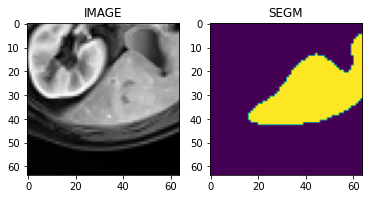

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.9627014398574829


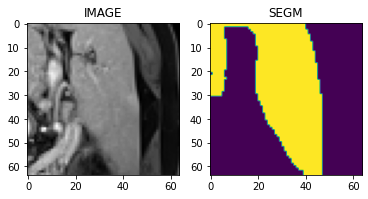

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.0773375034332275


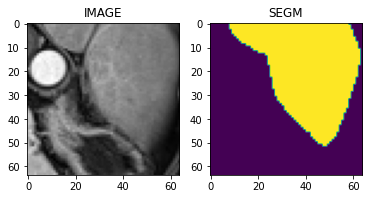

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5775574445724487


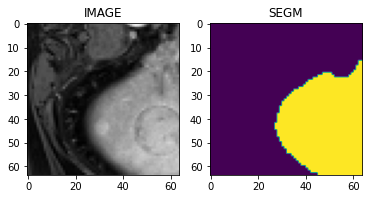

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8729733228683472


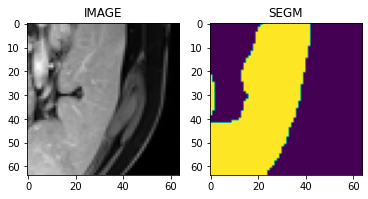

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.3554691076278687


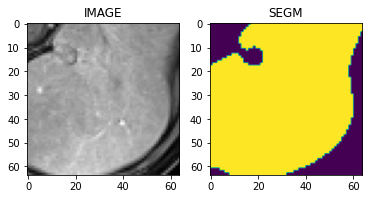

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.0373183488845825


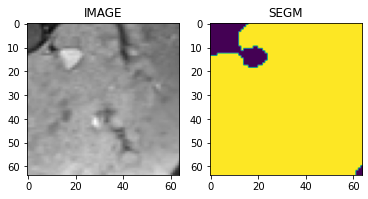

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.18074741959571838


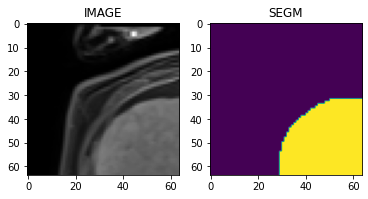

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.014877354726195335


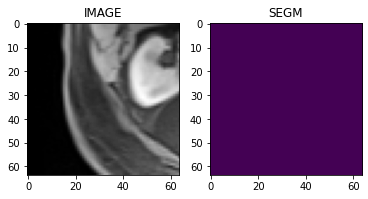

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.10065550357103348


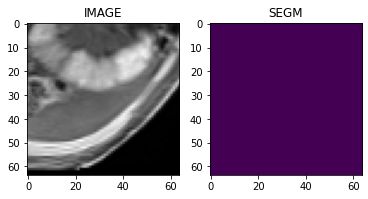

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.2290607988834381


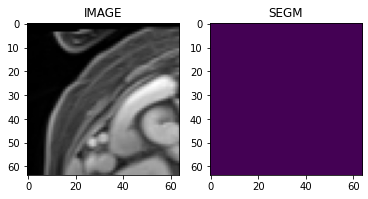

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6496378779411316


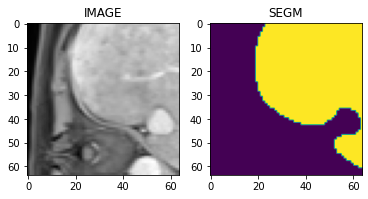

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7694482803344727


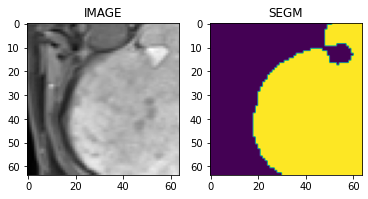

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.840920090675354


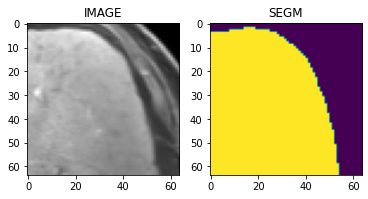

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.22272761166095734


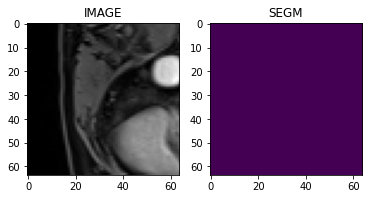

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6755126714706421


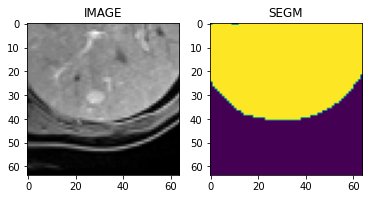

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.4832735061645508


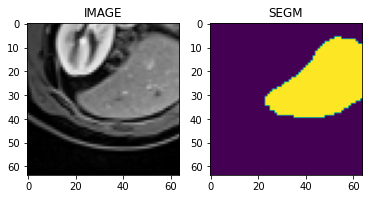

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.3228956460952759


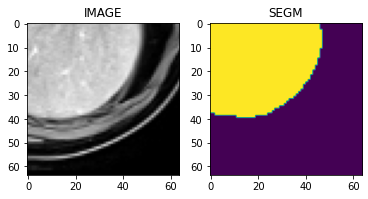

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.2996508777141571


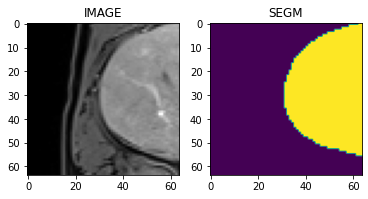

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6253273487091064


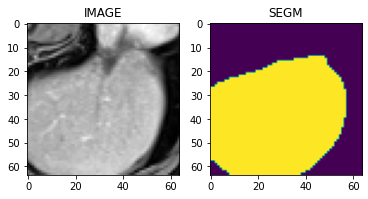

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.3687780201435089


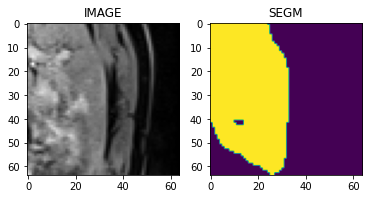

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.14647704362869263


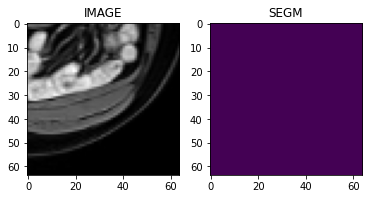

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.24171259999275208


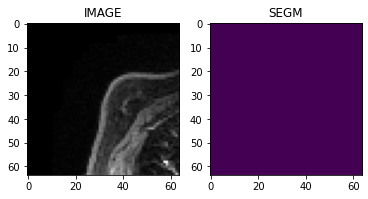

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.9686044454574585


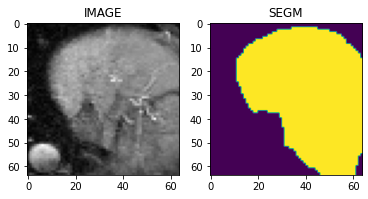

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.35643818974494934


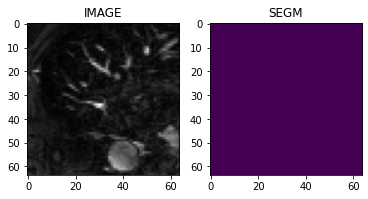

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.438211441040039


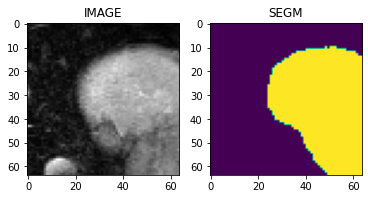

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.3383922576904297


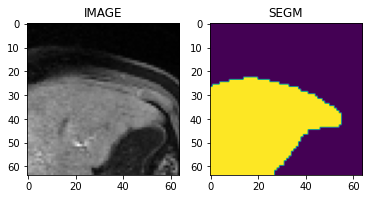

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.3716524541378021


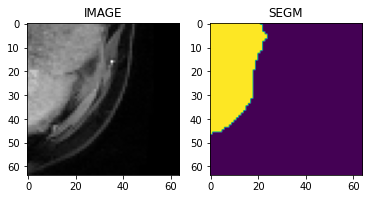

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.594811201095581


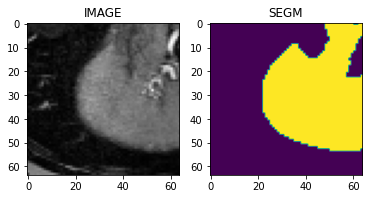

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.1591154336929321


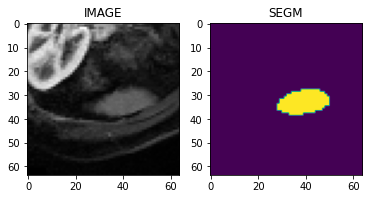

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.23044148087501526


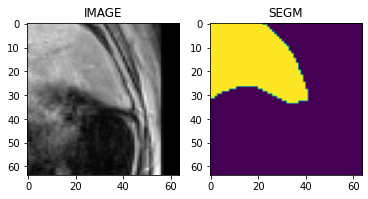

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.44487717747688293


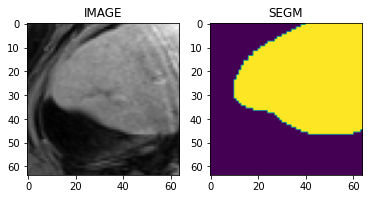

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.4098082184791565


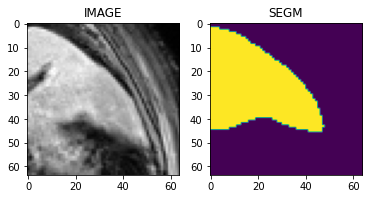

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.023853251710534096


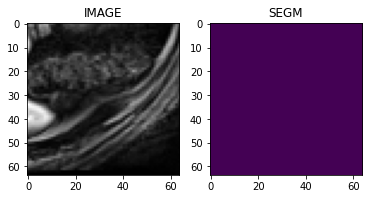

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6527175903320312


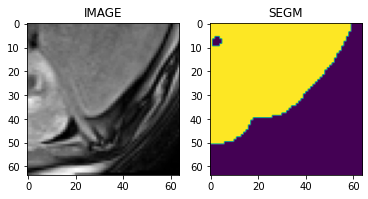

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.4063027799129486


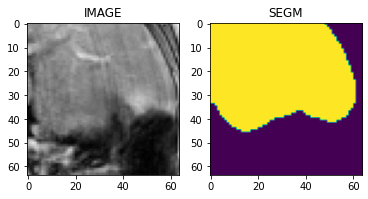

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.2062971144914627


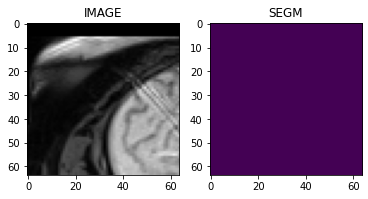

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.573861300945282


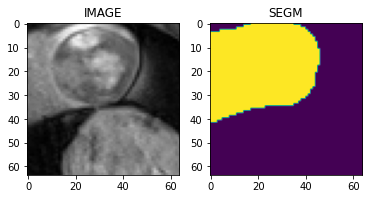

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7525582313537598


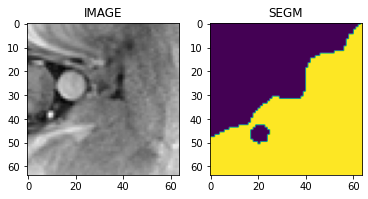

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7843630313873291


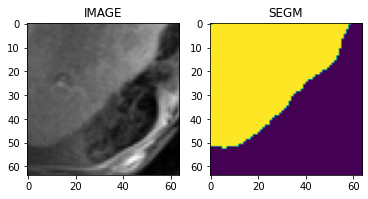

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7876524925231934


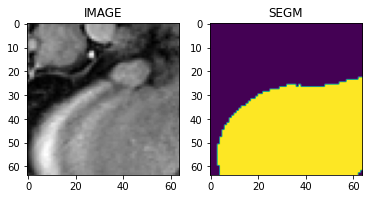

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7417965531349182


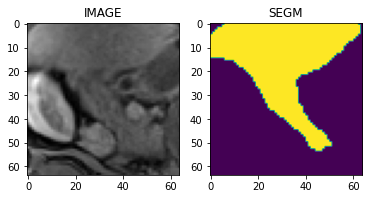

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8079380393028259


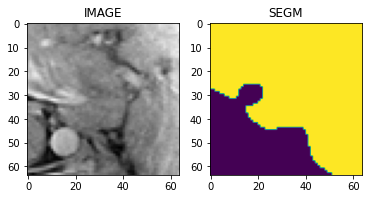

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7916403412818909


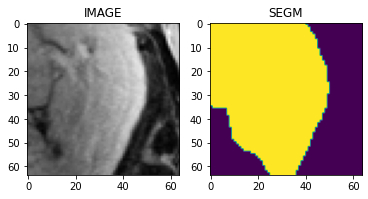

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7635400891304016


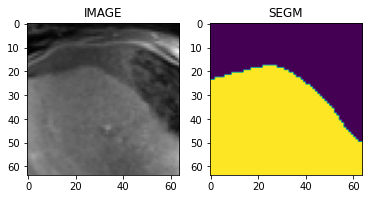

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7386747002601624


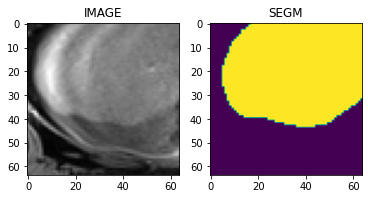

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.6723756790161133


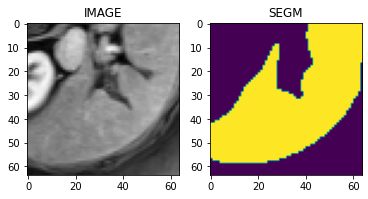

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.10431355237960815


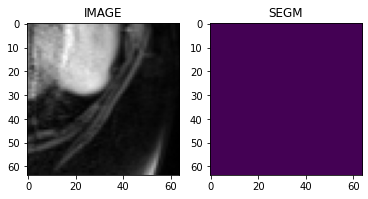

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.8706261515617371


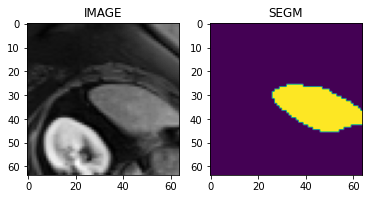

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.11318670213222504


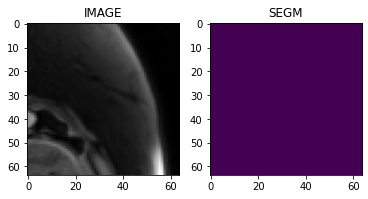

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.3561146259307861


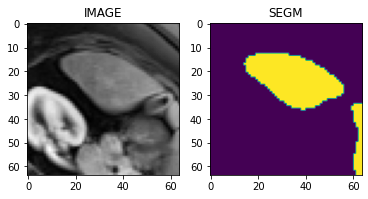

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7413511872291565


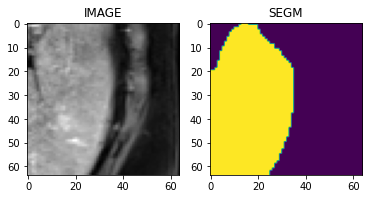

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.280420184135437


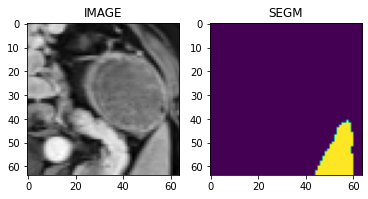

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.9784737825393677


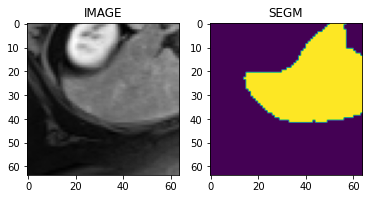

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5513178110122681


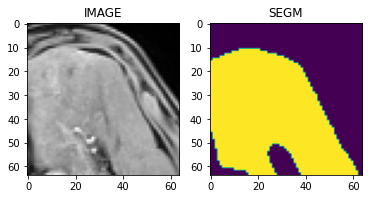

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6136110424995422


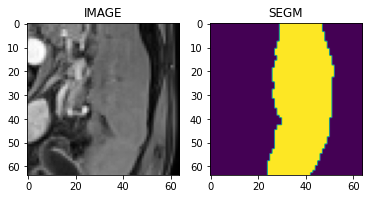

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.39835596084594727


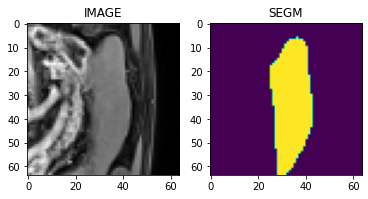

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6888196468353271


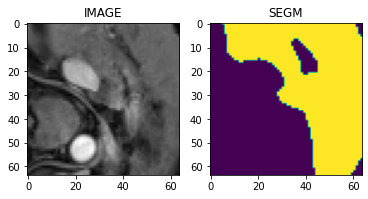

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.08814238011837006


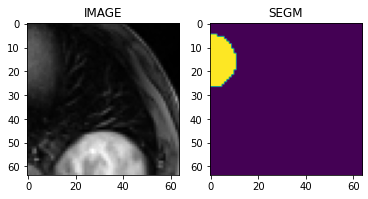

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.4459455609321594


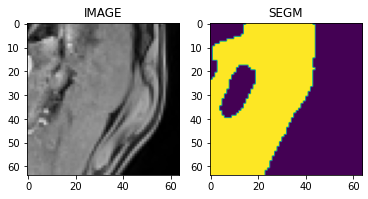

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5217355489730835


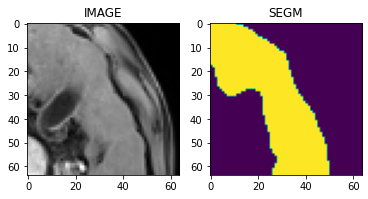

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: -0.14074522256851196


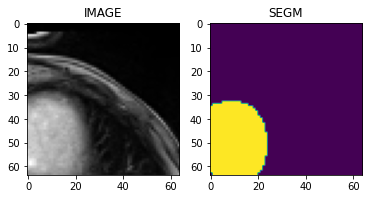

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5746960043907166


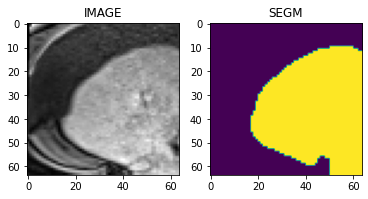

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.3913836181163788


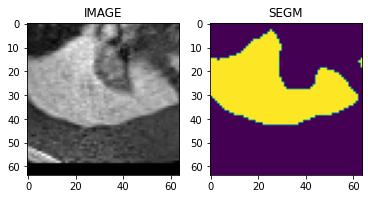

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6621633172035217


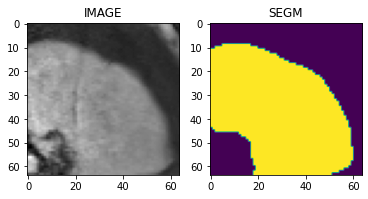

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.33174121379852295


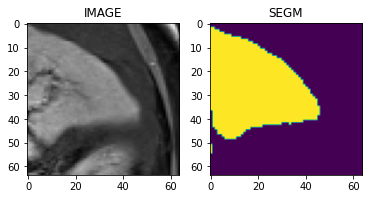

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.15923386812210083


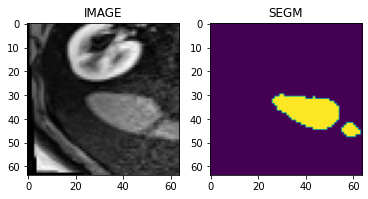

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.7896095514297485


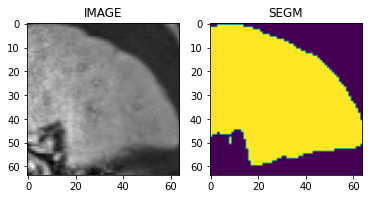

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6553685665130615


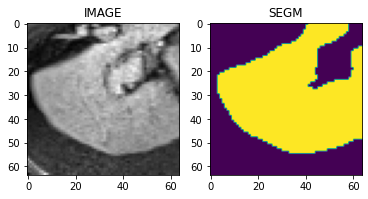

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6063360571861267


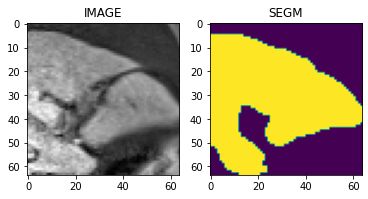

In [28]:
check_ds = monai.data.Dataset(data=train_data_dict[:12], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[:3], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=12, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10000
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create Segmentation Model (U-net)

In [29]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(64, 128, 256, 512),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        #print(batch['ACCESSION_ID'])
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [30]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,1,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       7,890
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,187,921
Trainable params: 1,187,921
Non-trainable params: 0
Total mult-adds (G): 1.67
Input size (MB): 0.52
Forward/backward pass size (MB): 45.22
Params size (MB): 4.75
Estimated Total Size (MB):

## Model Training

In [31]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-Net'

In [ ]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

## Model Testing

In [33]:
MODEL_ROOT_PATH

'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-Net'

In [34]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0699-val_loss=0.07.ckpt')

In [36]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [37]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [38]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET'

In [42]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=False, 
        save_output=True,
        output_path= OUTPUT_PATH)
#max_eval = 2

torch.cuda.empty_cache()

df_test_results['EXPERIMENT_ID'] = 'ART-Contrast-Imaging'
df_test_results.head()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4887d1d30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4887d1d30>self._shutdown_workers()Exception ignored in: 
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4887d1d30>    
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

if w.is_alive():    Traceback (most recent call last):

self._shutdown_workers()  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
      File "/home/mgross/an

0it [00:00, ?it/s]

can only test a child process
can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4887d1d30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9616121053695679
2.0
1.9682882546324063
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9634948968887329
1.4142135623730951
0.5570130182557907
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E100998852_T1_ART_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9733161926269531
1.4142135623730951
1.0822374810697812
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9736011624336243
1.4142135623730951
0.4663382666828866
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/12370686_T1_ART_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size

torch.Size([1, 2, 250, 187, 132])
0.9714460968971252
1.4142135623730951
0.5246826867032447
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9714460968971252
1.4142135623730951
0.5246826867032447
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E100207522_T1_ART_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.8889433741569519
73.46427703312679
16.74530753686884
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9680668115615845
1.7856406460552967
0.5897575138028093
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E104350920_T1_ART_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143

torch.Size([1, 2, 225, 149, 144])
0.9739210605621338
1.4142135623730951
0.45888059798219727
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9739455580711365
1.4142135623730951
0.44608183755018177
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/12957044_T1_ART_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9511268138885498
2.449489742783178
1.7774982437735682
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9521644115447998
2.449489742783178
0.9014213448963417
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E107891018_T1_ART_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151

0.9678121209144592
34.043348221890696
4.612758099263048
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.972693145275116
1.4142135623730951
0.5120675627897822
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E104998309_T1_ART_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9327108860015869
75.91442379216411
13.494382412600169
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9728073477745056
1.7320508075688772
0.5474762712431015
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E105615985_T1_ART_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9702342748641968
1.732050

torch.Size([1, 2, 201, 151, 120])
0.9711741805076599
1.4142135623730951
0.5546448924983908
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E107046127_T1_ART_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9564201235771179
3.1622776601683795
2.4633778762093734
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9584967494010925
2.23606797749979
0.5971286322587558
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/13106408_T1_ART_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9425036907196045
73.73398105856559
7.58867361387023
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120

torch.Size([1, 2, 190, 149, 120])
0.958104133605957
2.0
0.6593559398543749
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/12543786_T1_ART_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9342727661132812
73.01369734508724
6.537941709415133
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9401872158050537
3.4641016151377544
1.1042406499944195
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-NET/E107077373_T1_ART_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9649405479431152
1.7320508075688772
1.370962887676872
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.966065466

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.961612   0.963495   2.000000   1.414214       0.011847   
1  0.973316   0.973601   1.414214   1.414214       0.005282   
2  0.957831   0.966913  34.603467   1.414214       0.009089   
3  0.958294   0.972652  45.530210   1.414214       0.012997   
4  0.941912   0.955494  70.526591   3.000000       0.007178   

                                AUTOMATED-LIVER-SEGM         EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  ART-Contrast-Imaging  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  ART-Contrast-Imaging  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  ART-Contrast-Imaging  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  ART-Contrast-Imaging  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  ART-Contrast-Imaging

In [53]:
for i in [df_test_results]:
    for idx, row in  i.iterrows():
            i.loc[idx, 'ACCESSION_ID'] = str(row['AUTOMATED-LIVER-SEGM'].split('/')[-1].split('_')[-4])


In [55]:
df_test_results.to_csv('Results/Results-ART-Net.csv')

## External Testing

In [41]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_ART' : 'IMAGE', 'LIVER': 'SEGM'}, inplace = True)
df_external_testing

ACCESSION_ID                                             PV_PRE  \
0              1  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1              3  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2              4  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3              6  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4             10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5             11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6             12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7             17  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8             18  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9             19  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10            22  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11            32  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12            35  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13            40  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14            55  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15            59  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                IMAGE  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                   PV  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                               PV_DEL  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1

In [42]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [43]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 230, 230, 125])
image shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
image mean: 0.3059632182121277


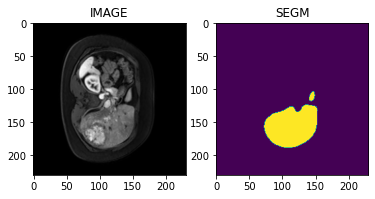

In [44]:
check_ds = monai.data.Dataset(data=external_test_data_dict[1:2], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the predicti

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 208 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarni

0.8975549936294556
4.478108006504773
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 206 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 207 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: 

0.897559642791748
4.475715662007166
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


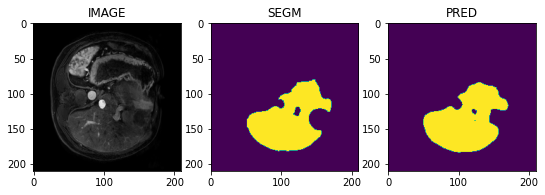

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 225 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 226 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 226 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWar

0.895142674446106
11.28222826157861
inf
0.8957487940788269
10.033101624024024
inf
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


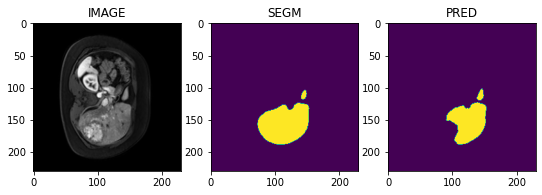

0.9366669058799744
6.284120346329065
inf
0.9371836185455322
3.4567099963162535
inf
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


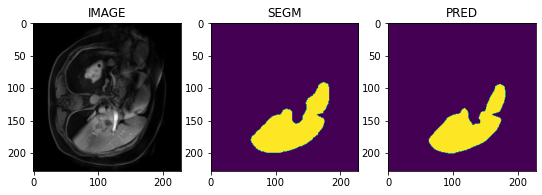

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 83 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9388263821601868
11.917629371883413
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9438035488128662
3.3744058641991646
inf
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


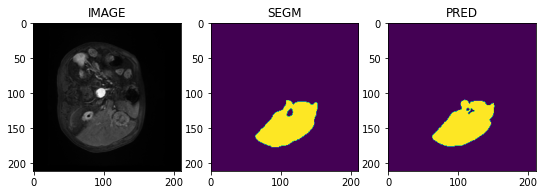

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.8852519989013672
14.817658671978638
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


0.9090256690979004
6.143746637680148
inf
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


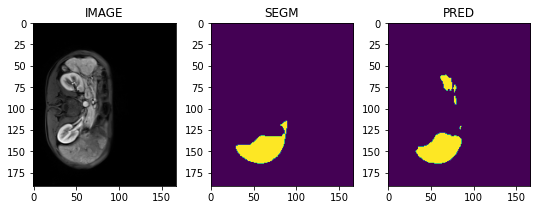

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.909225583076477
4.7523464684665155
inf
0.9092456698417664
4.7523464684665155
inf
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


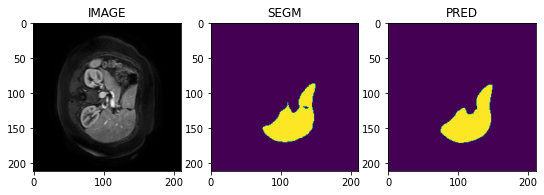

0.9115991592407227
2.690642889682014
inf
0.911604642868042
2.6881428896820143
inf
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


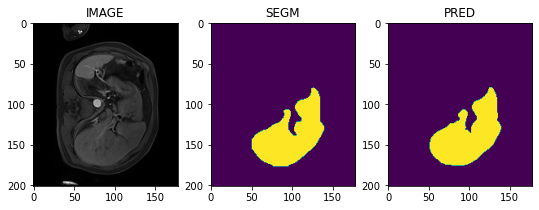

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 92 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWa

0.887496829032898
7.947337158332226
inf
0.8875055313110352
7.9448741041450335
inf
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


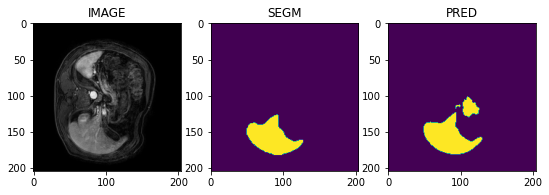

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9216200709342957
11.292963042283887
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 160 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 162 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9457842111587524
3.448701750863588
inf
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


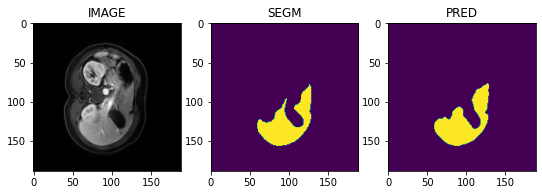

0.9427863359451294
3.871348160254053
inf
0.9434807300567627
2.8702726364104527
inf
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


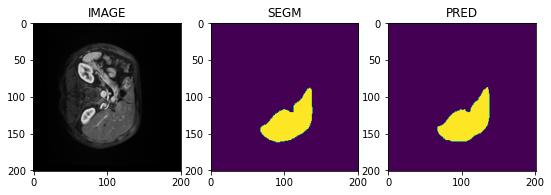

0.9379898905754089
6.962235262930197
inf
0.9427157044410706
4.004273649257713
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


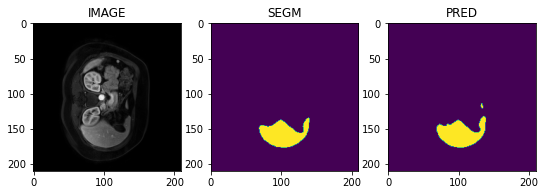

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9454182982444763
36.67285411724659
inf
0.954440712928772
2.6591133653849006
inf
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


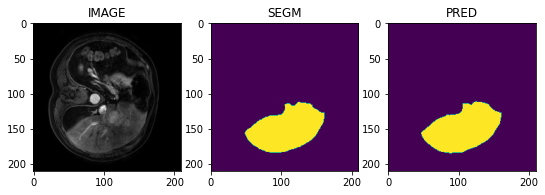

0.9662730693817139
2.8574333200852977
inf
0.9662730693817139
2.8574333200852977
inf
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


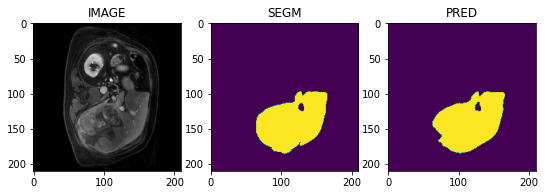

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning

0.9461313486099243
5.392303414381677
inf
0.9461523294448853
5.389379437773489
0.9824789745363425
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


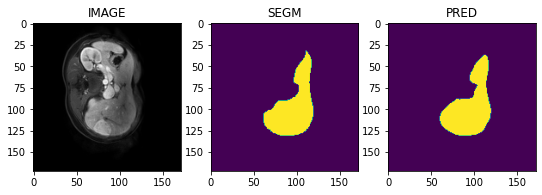

0.9617264866828918
2.4549384374428125
inf
0.9619640111923218
2.127913381833239
inf
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


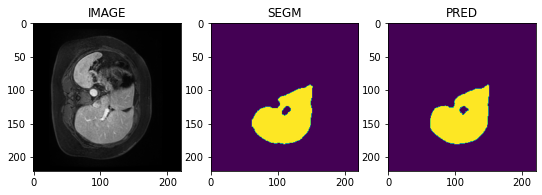

0.9377036094665527
15.653900588635477
inf
0.9394717812538147
3.597966456091961
inf
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


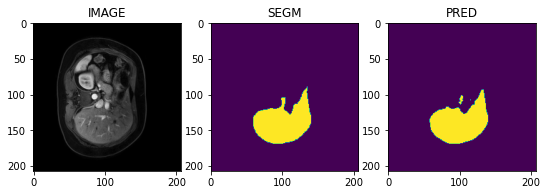

[0.8975549936294556, 0.895142674446106, 0.9366669058799744, 0.9388263821601868, 0.8852519989013672, 0.909225583076477, 0.9115991592407227, 0.887496829032898, 0.9216200709342957, 0.9427863359451294, 0.9379898905754089, 0.9454182982444763, 0.9662730693817139, 0.9461313486099243, 0.9617264866828918, 0.9377036094665527]


DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  16.000000  16.000000  16.000000  16.000000      16.000000
mean    0.926338   0.930747   9.333003   4.364006       0.006496
std     0.025732   0.024969   8.453532   2.127850       0.002919
min     0.885252   0.887506   2.454938   2.127913       0.003667
25%     0.906308   0.909191   4.326418   2.867063       0.004556
50%     0.937185   0.941094   6.623178   3.527338       0.005163
75%     0.943444   0.945876  11.449130   4.911605       0.007779
max     0.966273   0.966273  36.672854  10.033102       0.013627

In [45]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'ART-Contrast-Imaging'
df_external_test_results.describe()

In [47]:
df_external_test_results.to_csv('ExternalTestingResults/Results-ART-Net.csv')